# C/GMRES (single-shooting) example

In [7]:
import numpy as np
import scipy as sci
import time
import matplotlib.pyplot as plt


class CGMRES:
    def __init__(self):
        self.t0 = 0.0
        self.T_mpc = 20
        # self.T_mpc = 0.0
        self.dt_mpc = 4e-3
        # self.dt_mpc = 1e-3

        ### horizon
        self.Tf = 1.0
        self.N = 5
        self.alpha = 0.5

        ### current horizon length
        self.Tcur = 0.0
        self.dtau = self.Tcur / self.N

        ### C/GMRES parameters
        self.zeta = 1.0/self.dt_mpc
        self.h_fd = 1e-6
        self.m_gmres = 5
        self.initial_error_tol = 1e-6

        ### cost weight
        self.q = np.array([1.0, 10.0])
        self.r = np.array([1.0, 0.01])
        self.qf = np.array([1.0, 10.0])
        
        ### bound of input
        self.umin = 0.0
        self.umax = 1.0

        ### initial condition
        self.x0 = np.array([2.0, 0.0])
        self.u0 = np.array([0.01, 0.9])
        self.mu0 = np.array([0.03])
        self.v0 = np.concatenate([self.u0, self.mu0])
        self.lam0 = np.array([0.0, 0.0])

        ### reference
        self.xref = np.array([0.0, 0.0])
        self.uref = np.array([0.0, 0.0])

        ### dimension
        self.nx = len(self.x0)
        self.nu = len(self.u0)
        self.nc = len(self.mu0)
        self.nv = self.nu + self.nc

        ### variable
        self.X = np.zeros((self.N + 1, self.nx))
        # self.U = np.zeros(self.N * self.nv)
        self.U = np.tile(self.v0, self.N)
        self.Lam = np.zeros((self.N + 1, self.nx))
        self.Udot = np.zeros(self.N * self.nv)

        self.opt_error = None

        ### local constants
        self.a = -1
        self.b = -1

    def calc_f(self, x: np.ndarray, u: np.ndarray, t: float):
        f = np.array([
            x[1],
            self.a * x[0] + self.b * x[1] * u[0]
        ])
        return f
    
    def calc_fx(self, x: np.ndarray, u: np.ndarray, t: float):
        fx = np.array([
            [0, 0],
            [self.a, self.b * u[0]]
        ])
        return fx
        
    def calc_fu(self, x: np.ndarray, u: np.ndarray, t: float):
        fu = np.array([
            [0, 0],
            [self.b * x[1], 0]
        ])
        return fu
    

    def calc_l(self, x: np.ndarray, u: np.ndarray, t: float):
        xres = x - self.xref
        ures = u - self.uref
        l = 0.5*self.q[0]*xres[0]**2 + 0.5*self.q[1]*xres[1]**2 \
            + 0.5*self.r[0]*ures[0]**2 - self.r[1]*ures[1]
        return l

    def calc_lx(self, x: np.ndarray, u: np.ndarray, t: float):
        xres = x - self.xref
        ures = u - self.uref
        lx = np.array([
            self.q[0] * xres[0],
            self.q[1] * xres[1]
        ])
        return lx

    def calc_lu(self, x: np.ndarray, u: np.ndarray, t: float):
        xres = x - self.xref
        ures = u - self.uref
        lu = np.array([
            self.r[0] * ures[0],
            -self.r[1]
        ])
        return lu
        
    def calc_lf(self, x: np.ndarray, t: float):
        xres = x - self.xref
        lf = 0.5*self.qf[0]*xres[0]**2 + 0.5*self.qf[1]*xres[1]**2
        return lf

    def calc_lfx(self, x: np.ndarray, t:float):
        lfx = np.array([
            self.qf[0]*x[0],
            self.qf[1]*x[1]
        ])
        return lfx

    def calc_C(self, x: np.ndarray, u: np.ndarray, t: float):
        C = np.array([
            (u[0] - 0.5*(self.umax + self.umin))**2 + u[1]**2 \
                - (0.5*(self.umax - self.umin))**2
        ])
        return C
    
    def calc_Cx(self, x: np.ndarray, u: np.ndarray, t: float):
        Cx = np.array([
            [0, 0]
        ])
        return Cx

    def calc_Cu(self, x: np.ndarray, u: np.ndarray, t: float):
        Cu = np.array([
            [2*(u[0] - 0.5*(self.umin + self.umax)), 2*u[1]]
        ])
        return Cu
    

    def calc_H(self, x: np.ndarray, u: np.ndarray, lam: np.ndarray, mu: np.ndarray, t: float):
        H = self.calc_l(x, u, t) + self.calc_f(x, u, t).T @ lam + self.calc_C(x, u, t).T @ mu
        return H
    
    def calc_Hx(self, x: np.ndarray, u: np.ndarray, lam: np.ndarray, mu: np.ndarray, t: float):
        Hx = self.calc_lx(x, u, t) + self.calc_fx(x, u, t).T @ lam \
            + self.calc_Cx(x, u, t).T @ mu
        return Hx
    
    def calc_Hu(self, x: np.ndarray, u: np.ndarray, lam: np.ndarray, mu: np.ndarray, t: float):
        Hu = self.calc_lu(x, u, t) + self.calc_fu(x, u, t).T @ lam \
            + self.calc_Cu(x, u, t).T @ mu
        return Hu
    
    def calc_Hv(self, x: np.ndarray, v: np.ndarray, lam: np.ndarray, t: float):
        u = v[0:self.nu]
        mu = v[self.nu:]
        Hu = self.calc_Hu(x, u, lam, mu, t)
        C = self.calc_C(x, u, t)
        return np.concatenate([Hu, C])
    
    def calc_Hvv(self, x: np.ndarray, v: np.ndarray, lam: np.ndarray, t: float):
        Hvv = np.zeros((self.nv, self.nv))
        Hv = self.calc_Hv(x, v, lam, t)
        for i in range(self.nv):
            e = np.eye(self.nv)[i]
            Hvv[:, i] = (self.calc_Hv(x, v + self.h_fd*e, lam, t) - Hv) / self.h_fd
        return Hvv

    def rollout_x(self, xt: np.ndarray, U: np.ndarray, t:float):
        xs = np.empty((self.N + 1, self.nx))
        xs[0] = xt

        for i in range(self.N):
            u = U[i][:self.nu]
            xs[i + 1] = xs[i] + self.calc_f(xs[i], u, t + i*self.dtau) * self.dtau

        return xs

    def rollout_lam(self, xs: np.ndarray, U:np.ndarray, t:float):
        lams = np.empty((self.N + 1, self.nx))
        lams[self.N] = self.calc_lfx(xs[self.N], t)
        
        for i in range(self.N - 1, -1, -1):
            u  = U[i][:self.nu]
            mu  = U[i][self.nu:]
            lams[i] = lams[i + 1] + self.calc_Hx(xs[i], u, lams[i + 1], mu, t + i*self.dtau) * self.dtau
        
        return lams

    def calc_F(self, U: np.ndarray, xt: np.ndarray, t: float):
        U = U.reshape((self.N, self.nv))
        F = np.empty((self.N, self.nv))

        xs = self.rollout_x(xt, U, t)
        lams = self.rollout_lam(xs, U, t)

        for i in range(self.N):
            Hv = self.calc_Hv(xs[i], U[i], lams[i + 1], t + i*self.dtau)
            F[i] = Hv
        
        return F.reshape(-1)

    def update_solution(self, xt: np.ndarray, t: float):
        U = self.U
        Udot0 = self.Udot

        ### Arnoldi iteration: get Hessenberg matrix and ONB
        Hm_, Vm1, r0_norm = self.arnoldi_fdgmres(U, Udot0, xt, t)

        ### You can solve directory: Hm_ * y = ||r0|| e1
        if False:
            e1 = np.eye(self.m_gmres + 1)[0]
            y, residual, rank, svals = sci.linalg.lstsq(Hm_, r0_norm * e1)
            self.Udot = Udot0 + Vm1[:, :self.m_gmres] @ y
            self.U = U + self.Udot * self.dt_mpc
            F_new = self.calc_F(self.U, xt, t)
            self.opt_error = np.linalg.norm(F_new)
            return

        ### Givens rotation: Triangulate Hm_
        e1 = np.zeros(self.m_gmres + 1)
        e1[0] = 1
        Rm_, gm_ = self.givens_rotation(Hm_, r0_norm*e1)
        
        ### Backward substitution: solve Rm * y = gm
        y = self.backward_substitution(Rm_[0:self.m_gmres, :], gm_[0:self.m_gmres])

        self.Udot = Udot0 + Vm1[:, 0:self.m_gmres] @ y
        self.U = U + self.Udot * self.dt_mpc
        F_new = self.calc_F(self.U, xt, t)
        self.opt_error = np.linalg.norm(F_new)
        return

    def arnoldi_fdgmres(self, U: np.ndarray, Udot0: np.ndarray, xt: np.ndarray, t: float):
        xdot = self.calc_f(xt, U[0:self.nu], t)

        FUxt = self.calc_F(U + Udot0*self.h_fd, xt + xdot*self.h_fd, t + self.h_fd)
        Fxt = self.calc_F(U, xt + xdot*self.h_fd, t + self.h_fd)
        F = self.calc_F(U, xt, t)

        ### initial residual: r0 = b - A*Udot0
        b = -self.zeta * F - (Fxt - F) / self.h_fd
        A_Udot0 = (FUxt - Fxt) / self.h_fd
        r0 = b - A_Udot0
        r0_norm = np.linalg.norm(r0)

        ### Arnoldi iteration
        Hm_ = np.zeros((self.m_gmres + 1, self.m_gmres))
        Vm1 = np.zeros((self.N*self.nv, self.m_gmres + 1))
        Vm1[:, 0] = r0 / r0_norm

        for j in range(self.m_gmres):
            FUxt = self.calc_F(U + Vm1[:, j]*self.h_fd, xt + xdot*self.h_fd, t + self.h_fd)
            Avj = (FUxt - Fxt) / self.h_fd

            for i in range(j+1):
                Hm_[i, j] = Avj.T @ Vm1[:, i]

            vj1_hat = Avj
            for i in range(j+1):
                vj1_hat = vj1_hat - Hm_[i, j]*Vm1[:, i]

            Hm_[j+1, j] = np.linalg.norm(vj1_hat)
            Vm1[:, j+1] = vj1_hat / Hm_[j+1, j]

        return Hm_, Vm1, r0_norm

    def givens_rotation(self, Hm_: np.ndarray, gm_: np.ndarray):
        Rm_ = Hm_

        for i in range(self.m_gmres):
            den = np.sqrt(Rm_[i][i]**2 + Rm_[i+1][i]**2)
            ci = Rm_[i][i] / den
            si = Rm_[i+1][i] / den

            rot = np.array([[
                [ci, si],
                [-si, ci]
            ]])

            Rm_[i:i+2, :] = rot @ Rm_[i:i+2, :]
            gm_[i:i+2] = rot @ gm_[i:i+2]
        
        return Rm_, gm_

    def backward_substitution(self, Rm: np.ndarray, gm: np.ndarray):
        y = np.zeros(self.m_gmres)

        y = np.zeros(self.m_gmres)
        for i in range(self.m_gmres - 1, -1, -1):
            y[i] = (gm[i] - (Rm[i, i+1:].T @ y[i+1:])) / Rm[i, i]
        
        return y

    def update_horizon(self, t: float):
        self.Tcur = self.Tf * (1 - np.exp(-self.alpha * (t - self.t0)))
        self.dtau = self.Tcur / self.N

    def get_control_input(self):
        return self.U[0:self.nu]

    def RK4(self, x, u, t, dt):
        k1 = self.calc_f(x, u, t)
        k2 = self.calc_f(x + 0.5*dt*k1, u, t)
        k3 = self.calc_f(x + 0.5*dt*k2, u, t)
        k4 = self.calc_f(x + dt*k3, u, t)
        x_next = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6
        return x_next

    def initial_newton(self):
        self.lam0 = self.calc_lfx(self.x0, self.t0)
        opt_error = np.inf

        while opt_error >= self.initial_error_tol / np.sqrt(self.N):
            Hvv = self.calc_Hvv(self.x0, self.v0, self.lam0, self.t0)
            Hv = self.calc_Hv(self.x0, self.v0, self.lam0, self.t0)
            dv = -np.linalg.solve(Hvv, Hv)
            self.v0 = self.v0 + dv
            opt_error = np.linalg.norm(Hv)
            # print('Hv')
            # print(Hv)

        self.opt_error = opt_error / np.sqrt(self.N)
        self.u0 = self.v0[0:self.nu]
        self.mu0 = self.v0[self.nu:]

    def run(self):
        N_mpc = int(self.T_mpc / self.dt_mpc)
        t_hist = np.linspace(0, self.T_mpc, N_mpc+1)
        x_hist = []
        v_hist = []
        opt_error_hist = []

        ### initialize MPC
        self.initial_newton()

        print('initial input (u, udummy, mu):\n', self.v0)
        print('initial optError:\n', self.opt_error)

        self.U = np.tile(self.v0, self.N)
        self.Udot = self.U.copy()
        self.Udot = np.zeros(self.U.shape)

        t = 0.0
        xt = self.x0
        u = self.U[0:self.nv]

        ### MPC simulation
        timer = time.perf_counter()
        for i, t in enumerate(t_hist):
            print('t, x(t):\n', t, ',\n', xt, '\n')

            ### C/GMRES
            self.update_horizon(t)
            self.update_solution(xt, t)
            u = self.get_control_input()

            ### history
            x_hist.append(xt)
            v_hist.append(self.U[0:self.nv])
            opt_error_hist.append(self.opt_error)

            ### next state
            xt = self.RK4(xt, u, t, self.dt_mpc)
            t = t + self.dt_mpc
        elapsed = time.perf_counter() - timer

        print()
        print('final state:\n', xt)
        print('computation time[s]:\n', elapsed)
        # print('final norm of Udot:\n', self.Udot)

        self.t_hist = t_hist
        self.x_hist = np.array(x_hist)
        self.v_hist = np.array(v_hist)
        self.opt_error_hist = np.array(opt_error_hist)
        return


cgmres = CGMRES()
cgmres.run()


initial input (u, udummy, mu):
 [0.02839376 0.16609502 0.03010325]
initial optError:
 2.6667128419395103e-08
t, x(t):
 0.0 ,
 [2. 0.] 

t, x(t):
 0.004 ,
 [ 1.999984   -0.00799952] 

t, x(t):
 0.008 ,
 [ 1.99993601 -0.01599793] 

t, x(t):
 0.012 ,
 [ 1.99985602 -0.02399488] 

t, x(t):
 0.016 ,
 [ 1.99974405 -0.03198988] 

t, x(t):
 0.02 ,
 [ 1.9996001  -0.03998227] 

t, x(t):
 0.024 ,
 [ 1.9994242  -0.04797118] 

t, x(t):
 0.028 ,
 [ 1.99921634 -0.05595555] 

t, x(t):
 0.032 ,
 [ 1.99897656 -0.06393411] 

t, x(t):
 0.036000000000000004 ,
 [ 1.99870488 -0.07190539] 

t, x(t):
 0.04 ,
 [ 1.99840133 -0.07986772] 

t, x(t):
 0.044 ,
 [ 1.99806596 -0.08781925] 

t, x(t):
 0.048 ,
 [ 1.9976988  -0.09575797] 

t, x(t):
 0.052000000000000005 ,
 [ 1.99729992 -0.10368169] 

t, x(t):
 0.056 ,
 [ 1.99686938 -0.11158809] 

t, x(t):
 0.06 ,
 [ 1.99640725 -0.11947469] 

t, x(t):
 0.064 ,
 [ 1.99591362 -0.12733889] 

t, x(t):
 0.068 ,
 [ 1.99538858 -0.13517797] 

t, x(t):
 0.07200000000000001 ,
 [ 1.9

### Plot result

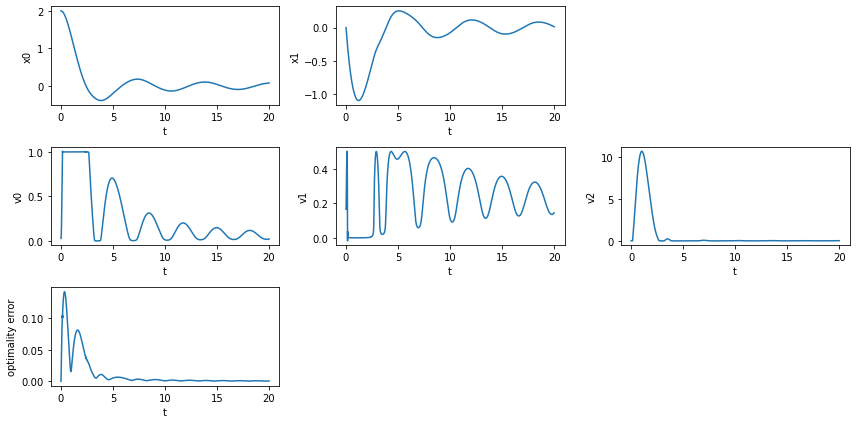

In [8]:
col = max(cgmres.nx, cgmres.nv)

fig, axes = plt.subplots(3, col, figsize=(12, 6), tight_layout=True)

for j in range(col):
    if j >= cgmres.nx:
        fig.delaxes(axes[0, j])
        break
    axes[0, j].set_xlabel('t')
    axes[0, j].set_ylabel(f'x{j}')
    axes[0, j].plot(cgmres.t_hist, cgmres.x_hist[:, j])

for j in range(col):
    if j >= cgmres.nv:
        fig.delaxes(axes[1, j])
        break
    axes[1, j].set_xlabel('t')
    axes[1, j].set_ylabel(f'v{j}')
    axes[1, j].plot(cgmres.t_hist, cgmres.v_hist[:, j])


axes[2, 0].set_xlabel('t')
axes[2, 0].set_ylabel(f'optimality error')
axes[2, 0].plot(cgmres.t_hist, cgmres.opt_error_hist)
for j in range(1, col):
    fig.delaxes(axes[2, j])
    
